In [1]:
from torchvision.datasets import CIFAR10
import numpy as np 
import torchvision.transforms as transforms
import torch 
from torch.utils.data.dataloader import DataLoader

## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

trainloader = DataLoader(c10train,batch_size=32,shuffle=True)
testloader = DataLoader(c10test,batch_size=32) 


Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Number of training examples: ',len(c10train))

Number of training examples:  50000


In [18]:
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices 
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")

# Finally we can define anoter dataloader for the training data
trainloader_subset = DataLoader(c10train_subset,batch_size=16,shuffle=True,num_workers=1)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.

Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 15000 samples


In [3]:
# Get ResNet from pytorch models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet18()

model.fc = nn.Linear(512,10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)


In [26]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, trainloader, device, optimizer, criterion, epochs=50, save_path=None):
    model.train()

    loss_values = []  # Empty list to store the loss values
    for epoch in tqdm(range(epochs), desc='Training', unit='epochs'):
        running_loss = 0.0
        for i, data in enumerate(trainloader,0):
            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                #print(f'[{epoch+1}] loss: {running_loss/100}')
                loss_values.append(running_loss/100)  # Append the loss value to the list
                running_loss = 0.0
    if save_path:
        # Save the model
        torch.save(model.state_dict(), save_path + '.pth')



    # Plotting the loss values
    plt.plot(loss_values)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss at each iteration')
    plt.show()
    return loss_values
#train_model(model, trainloader_subset, device, optimizer, criterion, epochs=50)

In [21]:
#Save the model
torch.save(model.state_dict(), 'RsNt18_subset_50epochs.pth')

In [ ]:
# load the model
model.load_state_dict(torch.load('RsNt18_subset_50epochs.pth'))

In [6]:
label_mapping = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(testloader, model, device, label_mapping):
    # Initialize the model to evaluation mode
    predicted_labels = []
    true_labels = []
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy_global = accuracy_score(true_labels, predicted_labels)
    print(f"Global accuracy: {accuracy_global}")

    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate accuracy by label
    accuracy_by_label = {}
    for i in range(len(label_mapping)):
        label = label_mapping[i]
        indices = np.where(np.array(true_labels) == i)[0]
        accuracy = accuracy_score(np.array(true_labels)[indices], np.array(predicted_labels)[indices])
        accuracy_by_label[label] = accuracy
    

    # Print the confusion matrix and accuracy by label
    print("Confusion Matrix:")
    print(cm)
    print("\nAccuracy by Label:")
    for label, accuracy in accuracy_by_label.items():
        print(f"{label}: {accuracy}")
    return accuracy_global, accuracy_by_label

Training: 100%|██████████| 50/50 [42:32<00:00, 51.05s/epochs]


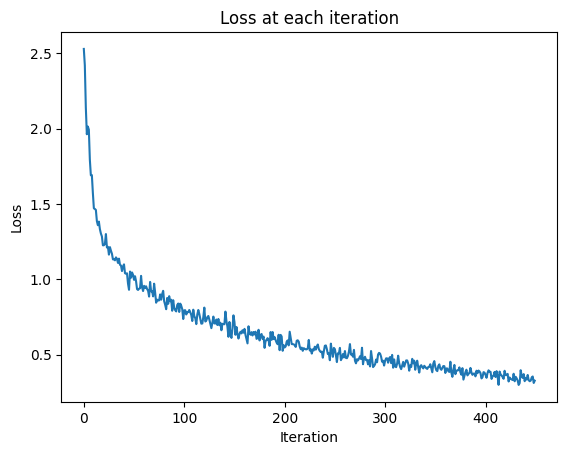

In [31]:
criterion = nn.CrossEntropyLoss() 
model_subset = resnet18()
model_subset.fc = nn.Linear(512,10)
model_subset = model_subset.to(device)
model_subset.load_state_dict(torch.load('RsNt18_subset_50epochs.pth'))
optimizer_subset = torch.optim.Adam(model_subset.parameters(), lr=0.008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_subset, 'min', patience=3, verbose=True)
loss=train_model(model_subset, trainloader_subset, device, optimizer_subset, criterion, save_path='RsNt18_subset_50epochs_lr001_noDecay_batchsize16', epochs=50)


In [32]:
# Evaluate the model
loss_model_subset = loss
accuracy_global, accuracy_by_label = evaluate_model(testloader, model_subset, device, label_mapping)

Global accuracy: 0.7802
Confusion Matrix:
[[725  19  36  20  10   7   8   9 143  23]
 [  8 890   3   4   2   3   5   0  33  52]
 [ 36   4 714  69  57  39  37   8  24  12]
 [ 11   9  51 687  44 131  28  11  20   8]
 [ 12   3  42  71 814  14  16  17  11   0]
 [  5   3  39 169  45 698  11  17  10   3]
 [  5   8  39 102  35  14 773   3  19   2]
 [ 10   2  30  64  64  80   5 728   3  14]
 [ 15  13   6   5   3   2   1   0 941  14]
 [ 12  90   6  11   1   4   5   4  35 832]]

Accuracy by Label:
airplane: 0.725
automobile: 0.89
bird: 0.714
cat: 0.687
deer: 0.814
dog: 0.698
frog: 0.773
horse: 0.728
ship: 0.941
truck: 0.832


In [ ]:
#Train model with all data
model_all_data = resnet18()
model_all_data.fc = nn.Linear(512,10)
model_all_data = model_all_data.to(device)
optimizer_all_data = optim.SGD(model_all_data.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)
train_model(model_all_data, trainloader, device, optimizer_all_data, criterion, epochs=10, save_path='RsNt18_all_data_50epochs')


In [ ]:
# Evaluate the model trained with all data and the model trained with the subset
evaluate_model(testloader, model_all_data, device, label_mapping)
evaluate_model(testloader, model, device, label_mapping)

In [50]:
# Implement a hyperparameter search with Optuna
import optuna

def objective(trial):
    # Generate a trial model
    model = resnet18()
    model.fc = nn.Linear(512,10)
    model = model.to(device)

    # Generate a trial optimizer
    optimizer = optim.SGD(model.parameters(), lr=trial.suggest_loguniform('lr', 0.001, 0.007), momentum=0.9, weight_decay=5e-4)

    # Train the model
    train_model(model, trainloader_subset, device, optimizer, criterion, epochs= trial.suggest_int('epochs', 50, 200), save_path='Optuna_model')

    # Evaluate the model
    model.eval()
    accuracy,_ = evaluate_model(testloader, model, device, label_mapping)

    # Calculate the accuracy

    return accuracy



[I 2024-04-09 17:52:05,693] A new study created in memory with name: no-name-6990be50-95f8-40d0-9d9d-0b6951a432c2
/var/folders/z8/5xwgt9dn43n0_s6896y6y4yc0000gn/T/ipykernel_99236/3164015185.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = optim.SGD(model.parameters(), lr=trial.suggest_loguniform('lr', 0.001, 0.007), momentum=0.9, weight_decay=5e-4)
  1%|          | 1/168 [00:14<39:02, 14.03s/it]

[1] loss: 9.422862590551377


  1%|          | 2/168 [00:27<38:05, 13.77s/it]

[2] loss: 7.792450266480446


  2%|▏         | 3/168 [00:41<37:51, 13.76s/it]

[3] loss: 7.237838609218597


  2%|▏         | 4/168 [00:54<37:25, 13.69s/it]

[4] loss: 6.76401636660099


  3%|▎         | 5/168 [01:08<36:59, 13.62s/it]

[5] loss: 6.309144909381867


  4%|▎         | 6/168 [01:22<36:54, 13.67s/it]

[6] loss: 5.934114470481872


  4%|▍         | 7/168 [01:35<36:42, 13.68s/it]

[7] loss: 5.630524178743363


  5%|▍         | 8/168 [01:49<36:34, 13.72s/it]

[8] loss: 5.36318727016449


  5%|▌         | 9/168 [02:03<36:27, 13.76s/it]

[9] loss: 5.1021829730272295


  6%|▌         | 10/168 [02:17<36:12, 13.75s/it]

[10] loss: 4.905500646829605


  7%|▋         | 11/168 [02:31<35:58, 13.75s/it]

[11] loss: 4.760140551328659


  7%|▋         | 12/168 [02:44<35:51, 13.79s/it]

[12] loss: 4.524000889658928


  8%|▊         | 13/168 [02:59<36:19, 14.06s/it]

[13] loss: 4.430608091056347


  8%|▊         | 14/168 [03:13<36:06, 14.07s/it]

[14] loss: 4.276755943596363


  9%|▉         | 15/168 [03:27<35:49, 14.05s/it]

[15] loss: 4.161425115466118


 10%|▉         | 16/168 [03:41<35:32, 14.03s/it]

[16] loss: 4.023747999370098


 10%|█         | 17/168 [03:55<35:24, 14.07s/it]

[17] loss: 3.903548299074173


 11%|█         | 18/168 [04:10<35:27, 14.19s/it]

[18] loss: 3.778951304554939


 11%|█▏        | 19/168 [04:25<35:36, 14.34s/it]

[19] loss: 3.7077313578128814


 12%|█▏        | 20/168 [04:39<35:27, 14.38s/it]

[20] loss: 3.5651040276885033


 12%|█▎        | 21/168 [04:53<34:59, 14.28s/it]

[21] loss: 3.55243594199419


 13%|█▎        | 22/168 [05:07<34:18, 14.10s/it]

[22] loss: 3.4191235914826392


 14%|█▎        | 23/168 [05:20<33:44, 13.96s/it]

[23] loss: 3.357293419241905


 14%|█▍        | 24/168 [05:35<34:07, 14.22s/it]

[24] loss: 3.2862638112902642


 15%|█▍        | 25/168 [05:49<33:55, 14.24s/it]

[25] loss: 3.187322819828987


 15%|█▌        | 26/168 [06:03<33:21, 14.09s/it]

[26] loss: 3.1213694149255753


 16%|█▌        | 27/168 [06:17<33:03, 14.07s/it]

[27] loss: 3.122536995112896


 17%|█▋        | 28/168 [06:31<32:45, 14.04s/it]

[28] loss: 3.0145498180389403


 17%|█▋        | 29/168 [06:45<32:23, 13.98s/it]

[29] loss: 2.9679759526252747


 18%|█▊        | 30/168 [06:59<31:53, 13.87s/it]

[30] loss: 2.8826093554496763


 18%|█▊        | 31/168 [07:12<31:31, 13.81s/it]

[31] loss: 2.782070584446192


 19%|█▉        | 32/168 [07:26<31:09, 13.74s/it]

[32] loss: 2.75589305087924


 20%|█▉        | 33/168 [07:40<30:53, 13.73s/it]

[33] loss: 2.709947653710842


 20%|██        | 34/168 [07:53<30:37, 13.71s/it]

[34] loss: 2.6628180238604546


 21%|██        | 35/168 [08:07<30:22, 13.71s/it]

[35] loss: 2.6106252306699753


 21%|██▏       | 36/168 [08:21<30:05, 13.68s/it]

[36] loss: 2.5751957762241364


 22%|██▏       | 37/168 [08:34<29:47, 13.64s/it]

[37] loss: 2.51325913310051


 23%|██▎       | 38/168 [08:48<29:31, 13.62s/it]

[38] loss: 2.4061092899739744


 23%|██▎       | 39/168 [09:01<29:18, 13.63s/it]

[39] loss: 2.4305035816133023


 24%|██▍       | 40/168 [09:15<29:03, 13.62s/it]

[40] loss: 2.3803510518372057


 24%|██▍       | 41/168 [09:29<28:50, 13.63s/it]

[41] loss: 2.322143271267414


 25%|██▌       | 42/168 [09:42<28:42, 13.67s/it]

[42] loss: 2.3018843917548657


 26%|██▌       | 43/168 [09:56<28:27, 13.66s/it]

[43] loss: 2.2576945407688616


 26%|██▌       | 44/168 [10:10<28:10, 13.64s/it]

[44] loss: 2.1925941367447375


 27%|██▋       | 45/168 [10:23<28:00, 13.66s/it]

[45] loss: 2.136726848110557


 27%|██▋       | 46/168 [10:37<27:51, 13.70s/it]

[46] loss: 2.178995748460293


 28%|██▊       | 47/168 [10:51<27:40, 13.73s/it]

[47] loss: 2.0870420104265213


 29%|██▊       | 48/168 [11:05<27:29, 13.74s/it]

[48] loss: 2.016331396996975


 29%|██▉       | 49/168 [11:19<27:20, 13.79s/it]

[49] loss: 2.0857494173944


 30%|██▉       | 50/168 [11:32<27:06, 13.78s/it]

[50] loss: 2.0270586272329094


 30%|███       | 51/168 [11:46<26:56, 13.82s/it]

[51] loss: 1.9730391503870488


 31%|███       | 52/168 [12:00<26:45, 13.84s/it]

[52] loss: 1.9105470160394906


 32%|███▏      | 53/168 [12:14<26:23, 13.77s/it]

[53] loss: 1.9259834749251603


 32%|███▏      | 54/168 [12:27<26:02, 13.70s/it]

[54] loss: 1.9210965149104595


 33%|███▎      | 55/168 [12:41<25:46, 13.68s/it]

[55] loss: 1.909306999593973


 33%|███▎      | 56/168 [12:55<25:33, 13.70s/it]

[56] loss: 1.8231822603940964


 34%|███▍      | 57/168 [13:08<25:16, 13.66s/it]

[57] loss: 1.8545599275827407


 35%|███▍      | 58/168 [13:22<25:03, 13.67s/it]

[58] loss: 1.8091287157684564


 35%|███▌      | 59/168 [13:36<24:49, 13.67s/it]

[59] loss: 1.7877144403755665


 36%|███▌      | 60/168 [13:49<24:38, 13.69s/it]

[60] loss: 1.7514951791614295


 36%|███▋      | 61/168 [14:03<24:27, 13.72s/it]

[61] loss: 1.7489148492366076


 37%|███▋      | 62/168 [14:17<24:14, 13.73s/it]

[62] loss: 1.6296101345866918


 38%|███▊      | 63/168 [14:31<24:01, 13.73s/it]

[63] loss: 1.763045240715146


 38%|███▊      | 64/168 [14:44<23:51, 13.76s/it]

[64] loss: 1.665902824923396


 39%|███▊      | 65/168 [14:59<24:02, 14.01s/it]

[65] loss: 1.6077203042805195


 39%|███▉      | 66/168 [15:14<24:07, 14.19s/it]

[66] loss: 1.598957790285349


 40%|███▉      | 67/168 [15:28<23:49, 14.15s/it]

[67] loss: 1.65119821511209


 40%|████      | 68/168 [15:42<23:30, 14.11s/it]

[68] loss: 1.5394992630183697


 41%|████      | 69/168 [15:56<23:12, 14.06s/it]

[69] loss: 1.5849344461411237


 42%|████▏     | 70/168 [16:10<22:58, 14.07s/it]

[70] loss: 1.539152367413044


 42%|████▏     | 71/168 [16:24<22:47, 14.10s/it]

[71] loss: 1.5397011908516287


 43%|████▎     | 72/168 [16:38<22:38, 14.15s/it]

[72] loss: 1.5120035108923913


 43%|████▎     | 73/168 [16:52<22:24, 14.15s/it]

[73] loss: 1.528502348586917


 44%|████▍     | 74/168 [17:06<22:00, 14.05s/it]

[74] loss: 1.495211517214775


 45%|████▍     | 75/168 [17:20<21:33, 13.90s/it]

[75] loss: 1.4751230369508266


 45%|████▌     | 76/168 [19:29<1:14:12, 48.40s/it]

[76] loss: 1.458164021372795


 46%|████▌     | 77/168 [19:44<58:31, 38.59s/it]  

[77] loss: 1.4681756868213416


 46%|████▋     | 78/168 [19:57<46:28, 30.99s/it]

[78] loss: 1.4789013562351465


 47%|████▋     | 79/168 [20:11<38:00, 25.63s/it]

[79] loss: 1.4769948079437016


 48%|████▊     | 80/168 [22:34<1:29:16, 60.87s/it]

[80] loss: 1.3654077115654946


 48%|████▊     | 81/168 [22:47<1:07:32, 46.58s/it]

[81] loss: 1.4274398352578281


 49%|████▉     | 82/168 [23:00<52:23, 36.56s/it]  

[82] loss: 1.3966791942715644


 49%|████▉     | 83/168 [24:45<1:20:41, 56.95s/it]

[83] loss: 1.328833008185029


 50%|█████     | 84/168 [24:58<1:01:25, 43.88s/it]

[84] loss: 1.366758951433003


 51%|█████     | 85/168 [25:11<48:03, 34.74s/it]  

[85] loss: 1.352954030893743


 51%|█████     | 86/168 [25:25<38:41, 28.32s/it]

[86] loss: 1.321883611679077


 52%|█████▏    | 87/168 [31:01<2:42:52, 120.64s/it]

[87] loss: 1.3045702395960688


 52%|█████▏    | 88/168 [31:14<1:57:47, 88.35s/it] 

[88] loss: 1.315513711795211


 53%|█████▎    | 89/168 [31:27<1:26:36, 65.78s/it]

[89] loss: 1.3301346496492625


 54%|█████▎    | 90/168 [32:39<1:27:58, 67.67s/it]

[90] loss: 1.264306075386703


 54%|█████▍    | 91/168 [32:52<1:05:52, 51.33s/it]

[91] loss: 1.2956748128682376


 55%|█████▍    | 92/168 [33:06<50:35, 39.94s/it]  

[92] loss: 1.238478477410972


 55%|█████▌    | 93/168 [33:19<39:55, 31.94s/it]

[93] loss: 1.275935904122889


 56%|█████▌    | 94/168 [33:32<32:32, 26.38s/it]

[94] loss: 1.3025377794355153


 57%|█████▋    | 95/168 [33:46<27:22, 22.50s/it]

[95] loss: 1.258018624819815


 57%|█████▋    | 96/168 [33:59<23:44, 19.79s/it]

[96] loss: 1.2467361557856202


 58%|█████▊    | 97/168 [34:13<21:09, 17.87s/it]

[97] loss: 1.2496702728420497


 58%|█████▊    | 98/168 [34:26<19:16, 16.52s/it]

[98] loss: 1.1993033458665012


 59%|█████▉    | 99/168 [35:00<25:03, 21.78s/it]

[99] loss: 1.2335865347832442


 60%|█████▉    | 100/168 [44:29<3:30:51, 186.05s/it]

[100] loss: 1.1869227293878795


 60%|██████    | 101/168 [44:42<2:29:46, 134.13s/it]

[101] loss: 1.210255386196077


 61%|██████    | 102/168 [44:55<1:47:36, 97.83s/it] 

[102] loss: 1.1789188939332962


 61%|██████▏   | 103/168 [45:09<1:18:29, 72.45s/it]

[103] loss: 1.2000786917284132


 62%|██████▏   | 104/168 [45:22<58:21, 54.71s/it]  

[104] loss: 1.142682369761169


 62%|██████▎   | 105/168 [45:35<44:25, 42.31s/it]

[105] loss: 1.1631868626363575


 63%|██████▎   | 106/168 [45:49<34:43, 33.61s/it]

[106] loss: 1.1619325532764195


 64%|██████▎   | 107/168 [46:02<28:00, 27.55s/it]

[107] loss: 1.1617120557278395


 64%|██████▍   | 108/168 [46:15<23:15, 23.26s/it]

[108] loss: 1.2024575907364488


 65%|██████▍   | 109/168 [46:29<19:54, 20.24s/it]

[109] loss: 1.157916172929108


 65%|██████▌   | 110/168 [46:42<17:34, 18.19s/it]

[110] loss: 1.1198387117683888


 66%|██████▌   | 111/168 [46:55<15:52, 16.71s/it]

[111] loss: 1.0770965415239333


 67%|██████▋   | 112/168 [47:08<14:37, 15.66s/it]

[112] loss: 1.1272054262831808


 67%|██████▋   | 113/168 [47:22<13:44, 15.00s/it]

[113] loss: 1.1214576677232981


 68%|██████▊   | 114/168 [47:35<13:04, 14.52s/it]

[114] loss: 1.123800216447562


 68%|██████▊   | 115/168 [47:49<12:28, 14.13s/it]

[115] loss: 1.0500698785111309


 69%|██████▉   | 116/168 [48:20<16:49, 19.41s/it]

[116] loss: 1.1524625663645565


 70%|██████▉   | 117/168 [49:21<27:06, 31.90s/it]

[117] loss: 1.0488305239006877


 70%|███████   | 118/168 [49:55<27:02, 32.44s/it]

[118] loss: 1.0661822570487858


 71%|███████   | 119/168 [50:10<22:16, 27.27s/it]

[119] loss: 1.1160423377901316


 71%|███████▏  | 120/168 [50:26<19:07, 23.90s/it]

[120] loss: 1.0673465127497912


 72%|███████▏  | 121/168 [50:41<16:36, 21.21s/it]

[121] loss: 1.0864263591915369


 73%|███████▎  | 122/168 [50:56<14:49, 19.34s/it]

[122] loss: 1.0632323499768972


 73%|███████▎  | 123/168 [51:11<13:32, 18.05s/it]

[123] loss: 1.0387098265066743


 74%|███████▍  | 124/168 [51:27<12:38, 17.23s/it]

[124] loss: 1.1030402705445885


 74%|███████▍  | 125/168 [52:17<19:34, 27.32s/it]

[125] loss: 1.0200461779907346


 75%|███████▌  | 126/168 [52:56<21:32, 30.78s/it]

[126] loss: 1.0623282304406165


 76%|███████▌  | 127/168 [53:13<18:09, 26.57s/it]

[127] loss: 1.0222081493213773


 76%|███████▌  | 128/168 [53:30<15:42, 23.56s/it]

[128] loss: 1.0009294691681863


 77%|███████▋  | 129/168 [53:46<13:51, 21.31s/it]

[129] loss: 1.0866367200762033


 77%|███████▋  | 130/168 [54:02<12:32, 19.79s/it]

[130] loss: 1.0483400913886727


 78%|███████▊  | 131/168 [54:18<11:33, 18.74s/it]

[131] loss: 1.0076501268148421


 79%|███████▊  | 132/168 [54:35<10:50, 18.06s/it]

[132] loss: 1.0219182295538485


 79%|███████▉  | 133/168 [54:52<10:20, 17.72s/it]

[133] loss: 1.0146058875322341


 80%|███████▉  | 134/168 [55:16<11:08, 19.65s/it]

[134] loss: 1.0275335101038217


 80%|████████  | 135/168 [56:03<15:17, 27.80s/it]

[135] loss: 1.0144779866188764


 81%|████████  | 136/168 [56:22<13:30, 25.34s/it]

[136] loss: 0.991762755420059


 82%|████████▏ | 137/168 [56:41<12:09, 23.54s/it]

[137] loss: 0.9984993146732449


 82%|████████▏ | 138/168 [57:00<11:04, 22.15s/it]

[138] loss: 0.9878306019306183


 83%|████████▎ | 139/168 [57:19<10:12, 21.11s/it]

[139] loss: 0.9192868838459254


 83%|████████▎ | 140/168 [57:37<09:24, 20.18s/it]

[140] loss: 1.0042274387180805


 84%|████████▍ | 141/168 [57:56<08:52, 19.72s/it]

[141] loss: 0.9879569128435105


 85%|████████▍ | 142/168 [58:14<08:21, 19.28s/it]

[142] loss: 0.9902582805231214


 85%|████████▌ | 143/168 [58:33<08:00, 19.24s/it]

[143] loss: 0.9808878721483052


 86%|████████▌ | 144/168 [58:53<07:46, 19.43s/it]

[144] loss: 0.9176047392375767


 86%|████████▋ | 145/168 [59:13<07:33, 19.71s/it]

[145] loss: 0.9929313072562218


 87%|████████▋ | 146/168 [59:34<07:18, 19.95s/it]

[146] loss: 0.9308071241620928


 88%|████████▊ | 147/168 [59:55<07:06, 20.33s/it]

[147] loss: 0.9748139287158847


 88%|████████▊ | 148/168 [1:00:16<06:52, 20.61s/it]

[148] loss: 0.9906308367103338


 89%|████████▊ | 149/168 [1:00:39<06:45, 21.32s/it]

[149] loss: 0.9329269659891725


 89%|████████▉ | 150/168 [1:01:02<06:30, 21.68s/it]

[150] loss: 1.0051170142553747


 90%|████████▉ | 151/168 [1:01:24<06:08, 21.69s/it]

[151] loss: 0.9474140919744969


 90%|█████████ | 152/168 [1:01:45<05:45, 21.60s/it]

[152] loss: 0.9337273210287094


 91%|█████████ | 153/168 [1:02:08<05:30, 22.02s/it]

[153] loss: 0.9890214686840773


 92%|█████████▏| 154/168 [1:02:29<05:06, 21.87s/it]

[154] loss: 0.9347922270186245


 92%|█████████▏| 155/168 [1:02:51<04:41, 21.66s/it]

[155] loss: 0.9479011158272624


 93%|█████████▎| 156/168 [1:03:12<04:18, 21.58s/it]

[156] loss: 0.9545077313482762


 93%|█████████▎| 157/168 [1:03:33<03:53, 21.26s/it]

[157] loss: 0.9757081762515009


 94%|█████████▍| 158/168 [1:03:53<03:30, 21.00s/it]

[158] loss: 0.9265058207884431


 95%|█████████▍| 159/168 [1:04:13<03:07, 20.83s/it]

[159] loss: 0.9591339866258204


 95%|█████████▌| 160/168 [1:04:34<02:46, 20.80s/it]

[160] loss: 0.9778343894332647


 96%|█████████▌| 161/168 [1:04:55<02:25, 20.75s/it]

[161] loss: 0.9703891616500914


 96%|█████████▋| 162/168 [1:05:15<02:03, 20.64s/it]

[162] loss: 0.9046339152380825


 97%|█████████▋| 163/168 [1:05:36<01:43, 20.61s/it]

[163] loss: 0.8894137741439044


 98%|█████████▊| 164/168 [1:05:56<01:21, 20.43s/it]

[164] loss: 0.9338223798200488


 98%|█████████▊| 165/168 [1:06:15<01:00, 20.17s/it]

[165] loss: 0.8916218169778586


 99%|█████████▉| 166/168 [1:06:35<00:40, 20.10s/it]

[166] loss: 0.9765969038940966


 99%|█████████▉| 167/168 [1:06:55<00:20, 20.13s/it]

[167] loss: 0.8979447180218995


100%|██████████| 168/168 [1:07:15<00:00, 24.02s/it]

[168] loss: 0.8999329889193177


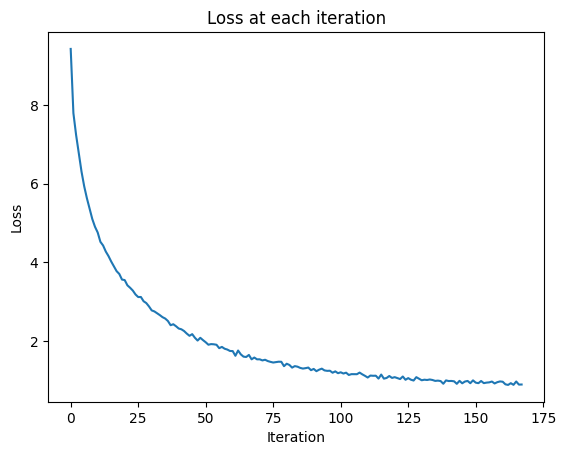

[I 2024-04-09 18:59:24,718] Trial 0 finished with value: 0.7581 and parameters: {'lr': 0.005174730363273795, 'epochs': 168}. Best is trial 0 with value: 0.7581.
/var/folders/z8/5xwgt9dn43n0_s6896y6y4yc0000gn/T/ipykernel_99236/3164015185.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = optim.SGD(model.parameters(), lr=trial.suggest_loguniform('lr', 0.001, 0.007), momentum=0.9, weight_decay=5e-4)


Global accuracy: 0.7581
Confusion Matrix:
[[780  14  55  18  18  10   6  12  67  20]
 [ 25 864   4  14   2   4   3   3  35  46]
 [ 46   4 734  48  75  33   9  34  11   6]
 [ 29  10  54 557  67 189  25  36  15  18]
 [ 20   1  57  37 762  36  11  63   9   4]
 [ 14   7  51 149  29 669   7  58  10   6]
 [  8   3  74  86  70  42 690  10   9   8]
 [ 15   3  28  36  44  47   2 811   4  10]
 [ 55   6  14   6   5   7   1   5 888  13]
 [ 26  62  12  11   2   6   3   4  48 826]]

Accuracy by Label:
airplane: 0.78
automobile: 0.864
bird: 0.734
cat: 0.557
deer: 0.762
dog: 0.669
frog: 0.69
horse: 0.811
ship: 0.888
truck: 0.826


  1%|          | 1/132 [00:21<47:42, 21.85s/it]

[1] loss: 9.3245443212986


  2%|▏         | 2/132 [00:42<45:10, 20.85s/it]

[2] loss: 7.668702917098999


  2%|▏         | 3/132 [01:01<43:17, 20.14s/it]

[3] loss: 6.979228001832962


  3%|▎         | 4/132 [01:21<43:19, 20.31s/it]

[4] loss: 6.504987050890922


  4%|▍         | 5/132 [01:42<43:00, 20.32s/it]

[5] loss: 6.118141946792602


  5%|▍         | 6/132 [02:02<42:29, 20.23s/it]

[6] loss: 5.88563547372818


  5%|▌         | 7/132 [02:22<42:24, 20.36s/it]

[7] loss: 5.577511522173881


  6%|▌         | 8/132 [02:42<41:48, 20.23s/it]

[8] loss: 5.374951508641243


  7%|▋         | 9/132 [03:02<41:22, 20.18s/it]

[9] loss: 5.130331813097


  8%|▊         | 10/132 [03:22<40:43, 20.03s/it]

[10] loss: 4.880659177303314


  8%|▊         | 11/132 [03:37<37:24, 18.55s/it]

[11] loss: 4.7414539730548855


  9%|▉         | 12/132 [03:52<35:01, 17.51s/it]

[12] loss: 4.64084365606308


 10%|▉         | 13/132 [04:06<32:31, 16.40s/it]

[13] loss: 4.450649637579918


 11%|█         | 14/132 [04:20<30:41, 15.60s/it]

[14] loss: 4.353629199266433


 11%|█▏        | 15/132 [04:34<29:24, 15.08s/it]

[15] loss: 4.182191348969936


 12%|█▏        | 16/132 [04:48<28:25, 14.70s/it]

[16] loss: 4.09333246320486


 13%|█▎        | 17/132 [05:01<27:38, 14.42s/it]

[17] loss: 4.004940604567528


 14%|█▎        | 18/132 [05:15<27:04, 14.25s/it]

[18] loss: 3.8709226790070534


 14%|█▍        | 19/132 [05:30<26:52, 14.27s/it]

[19] loss: 3.743499090373516


 15%|█▌        | 20/132 [05:44<26:42, 14.30s/it]

[20] loss: 3.686976233720779


 16%|█▌        | 21/132 [05:58<26:23, 14.27s/it]

[21] loss: 3.610847706198692


 17%|█▋        | 22/132 [06:12<26:06, 14.24s/it]

[22] loss: 3.546858816742897


 17%|█▋        | 23/132 [06:26<25:34, 14.07s/it]

[23] loss: 3.4938973718881607


 18%|█▊        | 24/132 [06:40<25:18, 14.06s/it]

[24] loss: 3.3281022499501707


 19%|█▉        | 25/132 [06:54<25:09, 14.11s/it]

[25] loss: 3.2824899700284003


 20%|█▉        | 26/132 [07:09<24:59, 14.14s/it]

[26] loss: 3.1770938521623613


 20%|██        | 27/132 [07:22<24:35, 14.05s/it]

[27] loss: 3.1288150210678576


 21%|██        | 28/132 [07:36<24:12, 13.97s/it]

[28] loss: 3.029553910493851


 22%|██▏       | 29/132 [07:50<23:50, 13.88s/it]

[29] loss: 3.0161086064577103


 23%|██▎       | 30/132 [08:04<23:33, 13.86s/it]

[30] loss: 2.92598101913929


 23%|██▎       | 31/132 [08:18<23:23, 13.89s/it]

[31] loss: 2.8491721980273725


 24%|██▍       | 32/132 [08:32<23:16, 13.97s/it]

[32] loss: 2.7713975186645983


 25%|██▌       | 33/132 [08:46<23:05, 14.00s/it]

[33] loss: 2.706846835166216


 26%|██▌       | 34/132 [09:00<22:48, 13.97s/it]

[34] loss: 2.6645671631395818


 27%|██▋       | 35/132 [09:14<22:49, 14.12s/it]

[35] loss: 2.6779004664719106


 27%|██▋       | 36/132 [09:28<22:29, 14.06s/it]

[36] loss: 2.6064164531230927


 28%|██▊       | 37/132 [09:42<22:11, 14.02s/it]

[37] loss: 2.52805104136467


 28%|██▊       | 37/132 [09:54<25:25, 16.05s/it]
[W 2024-04-09 19:09:18,897] Trial 1 failed with parameters: {'lr': 0.00343465286530756, 'epochs': 132} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ricardofernandezgasca/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/z8/5xwgt9dn43n0_s6896y6y4yc0000gn/T/ipykernel_99236/3164015185.py", line 14, in objective
    train_model(model, trainloader_subset, device, optimizer, criterion, epochs= trial.suggest_int('epochs', 50, 200), save_path='Optuna_model')
  File "/var/folders/z8/5xwgt9dn43n0_s6896y6y4yc0000gn/T/ipykernel_99236/3472054811.py", line 17, in train_model
    optimizer.step()
  File "/Users/ricardofernandezgasca/Library/Python/3.9/lib/python/site-packages/torch/optim/optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
  File "/Users/ricardofernandezgasca/Libra

KeyboardInterrupt: 

In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")
